In [ ]:
# 인용 : https://www.kaggle.com/asindico/customer-segments-with-pca
# 참조 : https://www.kaggle.com/mgabrielkerr/visualizing-knn-svm-and-xgboost-on-iris-dataset

+ **목적** : 구매이력 기반, 유의미한 그룹 분류
+ **방법** : Kernel PCA를 통한 차원축소 (6차원) 후, k-means (3-group)
+ **대상** : 19.09 PBS 구매회원 기준  
---  
+ **결론**
  + 그룹분류
    + 전체 : 라떼 선호 / 룽고 선호 /  S 사이즈 선호 
    + 임직원 : 아침식사 / 음료&제빵 / 주스류 구매
  + 기타 : 차원 선택 문제는 발생하지 않음

In [ ]:
#######
# import
###

import cx_Oracle as oci
import pandas as pd

from sklearn.decomposition import KernelPCA

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib as mpl
%matplotlib inline
import seaborn as sns
sns.set(style="white")
sns.set(style="whitegrid", color_codes=True)

In [ ]:
#######
#1. 자료추출(Oracel SQL)
###

## DB 접속
conn = oci.connect('*******************************************')

## query 실행( =자료 추출)
df_all = pd.read_sql("select S.stor_cd || S.pos_no || S.bill_no as order_no, S.Item_cd, S.sale_qty " + 
                     ", S.CUST_id "
                     "from sale_dt S, item I, c_cust C " +
                     "where S.sale_dt between '20190901' and '20190930' " +
                     "and S.item_cd = I.item_cd(+) " +
                     "and cust_stat <> 9 " +
                     "and C.cust_id = S.cust_id " +
                     "and S.t_seq = 0 " +
                     "and S.CUST_id is not null "
                      , con = conn )

## DB 접속종료
conn.close()

In [ ]:
### 자료확인
df_all.head(3)

,ORDER_NO,ITEM_CD,SALE_QTY,CUST_ID
0,20001230200043,179386,1,g2l777
1,20001230200064,179549,2,g2l777
2,20001230200040,170054,1,g2l777


In [ ]:
## pivot
cust_prod = pd.crosstab(df_all['CUST_ID'], df_all['ITEM_CD'])
cust_prod.head(5)

ITEM_CD,170039,170040,170048,170050,170052,170054,170055,170056,170058,170059,...,271036,271037,320005,320008,320022,320081,320084,320111,320117,320119
CUST_ID,,,,,,,,,,,,,,,,,,,,,
!junie77,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
!kby3831,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
#chrismh92,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
.??.,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
0008051,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
# PCA(차원축소)
pca = PCA(n_components=6)
pca.fit(cust_prod)
pca_samples = pca.transform(cust_prod)

# PCA(차원축소) - DataFrame
ps = pd.DataFrame(pca_samples)

In [ ]:
ps.head(5)

,0,1,2,3,4,5
0,0.558128,-0.397816,-0.242173,0.381456,-0.593856,0.100921
1,-0.505006,-0.011629,-0.237616,-0.150849,-0.081342,-0.384899
2,0.408606,-0.352276,-0.487554,-0.325082,0.003488,0.045768
3,-0.504887,-0.162222,-0.247122,-0.166497,-0.054127,-0.081303
4,-0.516064,-0.123842,-0.243494,-0.192408,-0.017740,0.030877


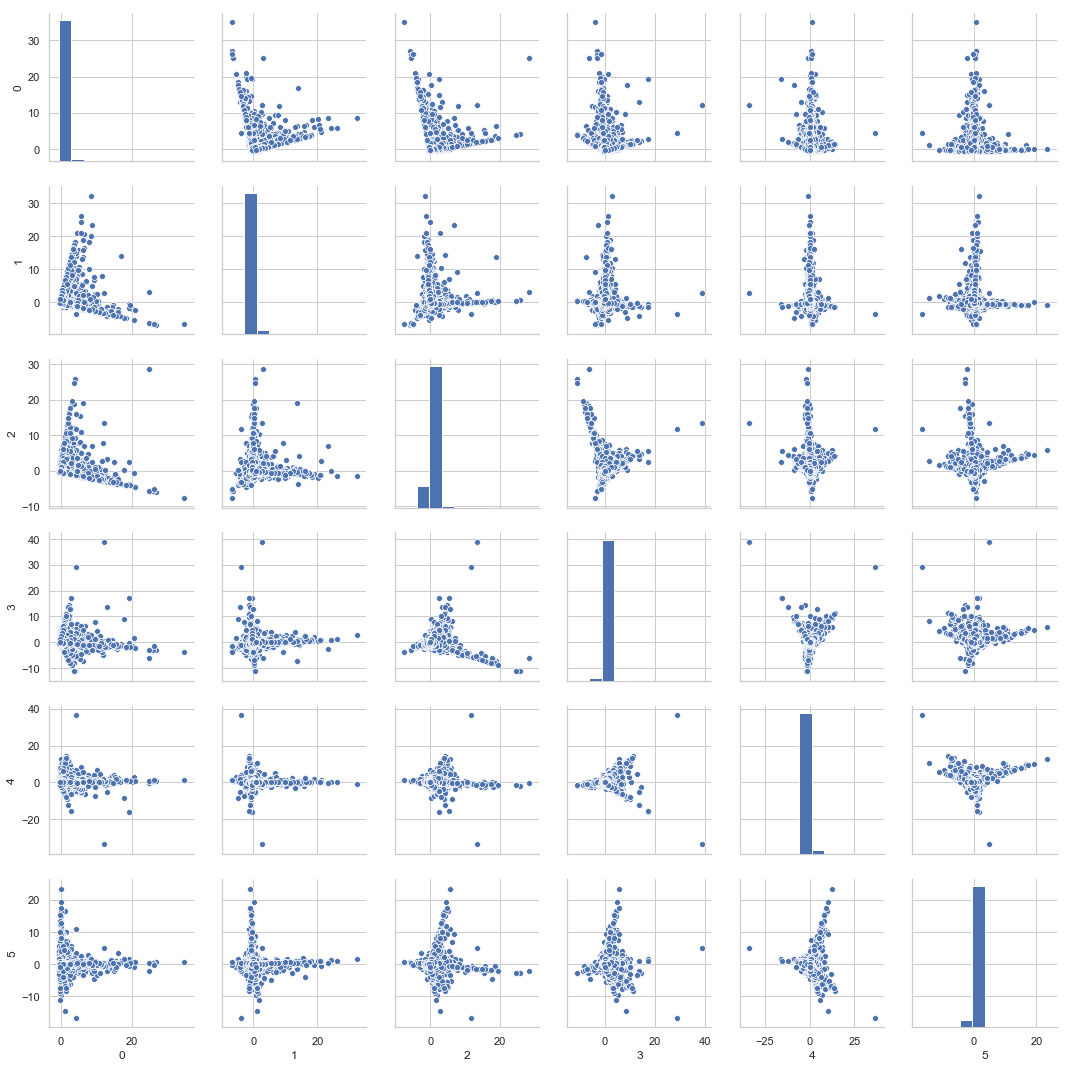

In [ ]:
sns.pairplot(ps)
plt.show()

['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'blue', 'orange', 'orange']


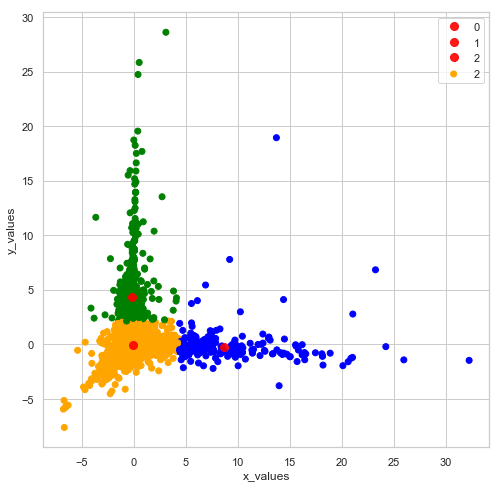

In [ ]:
tocluster = pd.DataFrame(ps[[1,2]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[2],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [ ]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()


In [ ]:
pd.DataFrame(c0.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170157,0.388320
179437,0.210102
179549,0.208717
179438,0.152046
170155,0.150488
170134,0.143218
170039,0.138579
170080,0.132140
170132,0.121166


In [ ]:
pd.DataFrame(c1.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170155,9.191729
170157,0.808271
170078,0.605263
170132,0.560150
179438,0.458647
170080,0.428571
179701,0.251880
170052,0.248120
270591,0.214286


In [ ]:
pd.DataFrame(c2.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170080,4.175637
170054,1.422096
170134,1.269122
179549,1.152975
179548,0.762040
170157,0.695467
170078,0.328612
170132,0.290368
170039,0.288952


In [ ]:
print (c_preds[0:100])

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 2 0 0 2 0 0 2 0 0 0 2 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0]


['green', 'green', 'green', 'green', 'green', 'green', 'green', 'orange', 'green', 'green']


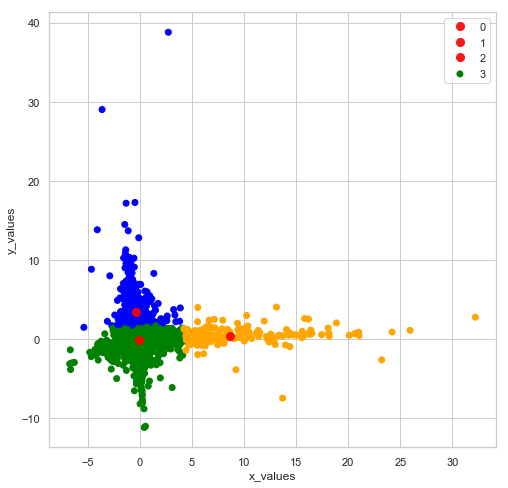

In [ ]:
tocluster = pd.DataFrame(ps[[1,3]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[3],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [ ]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [ ]:
pd.DataFrame(c0.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170155,9.152985
170157,0.802239
170078,0.615672
170132,0.593284
179438,0.455224
170080,0.425373
170052,0.272388
179701,0.250000
270591,0.212687


In [ ]:
pd.DataFrame(c1.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
179549,3.100524
170134,2.116230
170054,1.279581
170132,1.041885
179548,0.782199
170157,0.719372
179437,0.341361
170039,0.283770
179700,0.195812


In [ ]:
pd.DataFrame(c2.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170157,0.384879
170080,0.230417
179437,0.207054
179438,0.152122
170155,0.150550
170039,0.137454
179549,0.135568
170134,0.105151
179548,0.104557


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'blue', 'orange', 'orange']


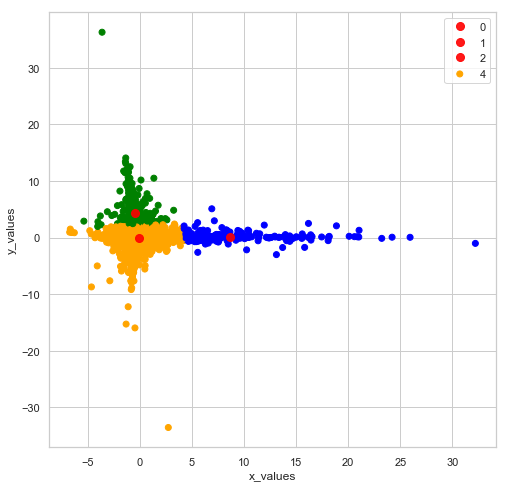

In [ ]:
tocluster = pd.DataFrame(ps[[1,4]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[4],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [ ]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [ ]:
pd.DataFrame(c0.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170157,0.387191
179549,0.231238
170080,0.227126
179437,0.211603
179438,0.152423
170155,0.150709
170039,0.139332
179548,0.126345
170134,0.112364


In [ ]:
pd.DataFrame(c1.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170155,9.152985
170157,0.802239
170078,0.615672
170132,0.593284
179438,0.455224
170080,0.425373
170052,0.272388
179701,0.250000
270591,0.212687


In [ ]:
pd.DataFrame(c2.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170134,4.296569
170054,3.544118
170132,2.080882
170157,1.002451
170039,0.345588
170080,0.335784
170052,0.321078
179549,0.232843
271015,0.223039


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'blue', 'orange', 'orange']


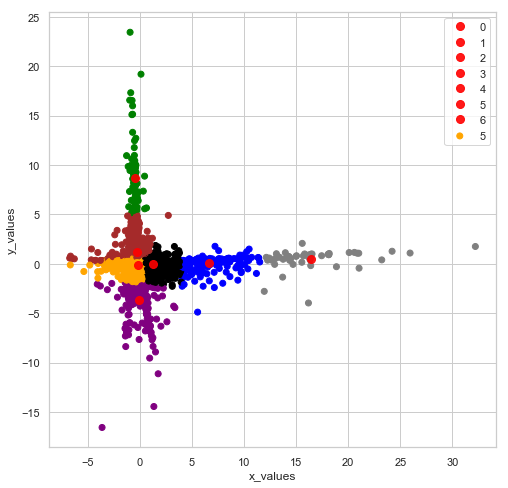

In [ ]:
tocluster = pd.DataFrame(ps[[1,5]])

clusterer = KMeans(n_clusters=7,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['black','blue','orange', 'brown', 'purple', 'green', 'gray']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[5],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [ ]:
c4 = clust_prod[clust_prod['cluster']==6].drop('cluster',axis=1).mean()
pd.DataFrame(c4.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170155,17.215686
170080,0.960784
170078,0.901961
170157,0.882353
179438,0.686275
170132,0.490196
179838,0.450980
270591,0.431373
270888,0.411765


In [ ]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [ ]:
pd.DataFrame(c0.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170157,0.396090
179549,0.229508
170080,0.227947
179437,0.212097
170134,0.166785
179438,0.151750
170155,0.150731
170039,0.141398
170132,0.125242


In [ ]:
pd.DataFrame(c1.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170155,9.191729
170157,0.808271
170078,0.605263
170132,0.560150
179438,0.458647
170080,0.428571
179701,0.251880
170052,0.248120
270591,0.214286


In [ ]:
pd.DataFrame(c2.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170054,9.325581
170134,0.922481
170052,0.728682
179549,0.627907
179548,0.503876
170080,0.379845
270888,0.356589
170039,0.317829
170157,0.294574


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


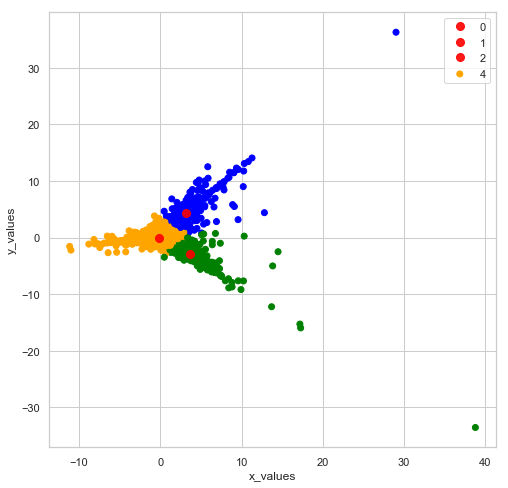

In [ ]:
tocluster = pd.DataFrame(ps[[3,4]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[3],tocluster[4],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [ ]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [ ]:
pd.DataFrame(c0.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170157,0.386548
170080,0.230607
170155,0.229015
179437,0.206456
179438,0.154764
179549,0.140267
170039,0.137638
170134,0.105425
179548,0.105391


In [ ]:
pd.DataFrame(c1.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170134,4.343750
170054,3.317308
170132,2.269231
170157,0.826923
170052,0.360577
170039,0.348558
179549,0.326923
170155,0.271635
179437,0.257212


In [ ]:
pd.DataFrame(c2.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
179549,5.016667
179548,1.242593
170157,0.753704
170134,0.390741
179437,0.379630
170155,0.307407
170039,0.220370
170132,0.214815
170080,0.200000


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange']


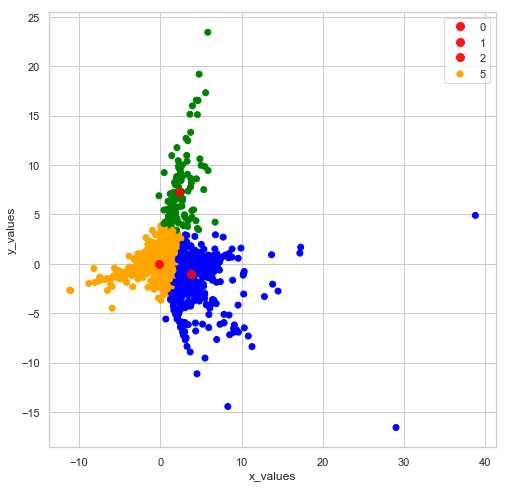

In [ ]:
tocluster = pd.DataFrame(ps[[3,5]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green','purple']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[3],tocluster[5],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [ ]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [ ]:
pd.DataFrame(c0.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170157,0.390410
170080,0.231149
170155,0.227561
179437,0.206588
179438,0.154467
179549,0.148430
170039,0.137461
179548,0.111073
170134,0.106451


In [ ]:
pd.DataFrame(c1.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
179549,3.462888
170134,2.499325
170132,1.527665
170157,0.767881
179548,0.689609
170155,0.399460
179437,0.383266
170054,0.333333
170039,0.292848


In [ ]:
pd.DataFrame(c2.sort_values(ascending=False)[0:10])

,0
ITEM_CD,
170054,9.456693
170134,1.000000
170052,0.708661
179548,0.370079
270888,0.362205
170080,0.354331
170039,0.314961
170157,0.283465
270591,0.267717


['orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'orange', 'blue', 'orange', 'orange']


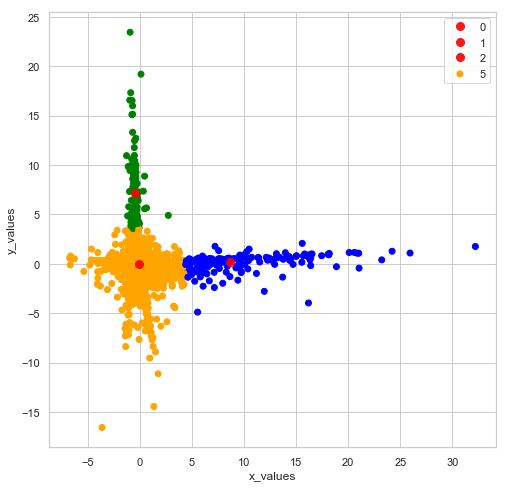

In [ ]:
tocluster = pd.DataFrame(ps[[1,5]])

clusterer = KMeans(n_clusters=3,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
# print(centers)

fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[1],tocluster[5],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [ ]:
clust_prod = cust_prod.copy()
clust_prod['cluster'] = c_preds

c0 = clust_prod[clust_prod['cluster']==0].drop('cluster',axis=1).mean()
c1 = clust_prod[clust_prod['cluster']==1].drop('cluster',axis=1).mean()
c2 = clust_prod[clust_prod['cluster']==2].drop('cluster',axis=1).mean()

In [ ]:
pd.DataFrame(c0.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,6.946602
170080,0.969256
179549,0.820388
170134,0.629450
170155,0.506472
179437,0.368932
170039,0.218447
179548,0.216828
179700,0.187702


In [ ]:
pd.DataFrame(c1.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170157,0.255747
179549,0.218502
170080,0.212806
179437,0.208043
170134,0.160235
179438,0.152019
170155,0.142285
170039,0.140525
170054,0.133448


In [ ]:
pd.DataFrame(c2.sort_values(ascending=False)[0:15])

,0
ITEM_CD,
170155,9.122222
170157,0.818519
170078,0.596296
170132,0.551852
179438,0.451852
170080,0.425926
179701,0.248148
170052,0.244444
179549,0.229630
